<a href="https://colab.research.google.com/github/yashraj01-se/Machine_learning_important_concepts/blob/main/GLM_project_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset:

In [ ]:
import torch
import pandas as pd

data=pd.read_csv("day.csv")
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


/tmp/ipython-input-2-2669374951.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_grouped = data.groupby('temp_bin')['cnt'].mean()


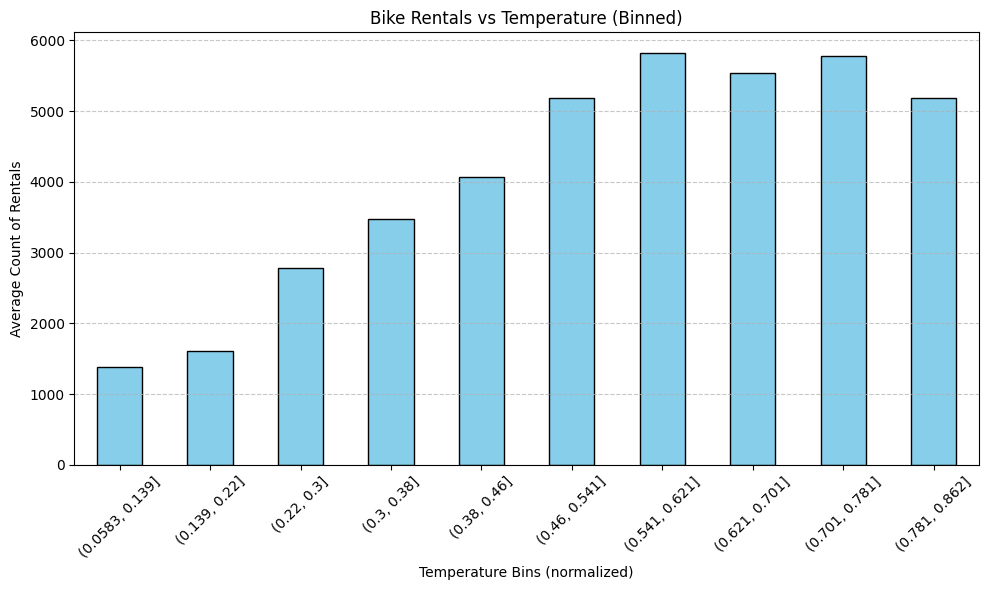

In [ ]:
import matplotlib.pyplot as plt
# Bin the 'temp' values into 10 ranges
data['temp_bin'] = pd.cut(data['temp'], bins=10)

# Group by bins and calculate average count per temp range
temp_grouped = data.groupby('temp_bin')['cnt'].mean()
plt.figure(figsize=(10,6))
temp_grouped.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Temperature Bins (normalized)')
plt.ylabel('Average Count of Rentals')
plt.title('Bike Rentals vs Temperature (Binned)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#Input Features:

In [ ]:
features = [
    'season',
    'holiday',
    'weekday',
    'workingday',
    'weathersit'
]

In [ ]:
X= pd.get_dummies(data[features], columns=['season', 'weekday', 'weathersit'], drop_first=True)

In [ ]:
y=np.log1p(data['cnt'].values)
print(X.shape,y.shape)

(731, 13) (731,)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
print("Dtype before coversion to tensor:",X.dtype,y.dtype)
print(type(X),type(y))
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
print("Dtype after coversion to tensor:",X.dtype,y.dtype)
print(type(X),type(y))

Dtype before coversion to tensor: float64 float64
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Dtype after coversion to tensor: torch.float32 torch.float32
<class 'torch.Tensor'> <class 'torch.Tensor'>


#Now we will create Model:

In [ ]:
torch.cuda.manual_seed(42)
from torch import nn
class Possison_reg(nn.Module):
  def __init__(self):
    super().__init__()
    self.Layer1=nn.Linear(in_features=13,out_features=32)
    self.Layer2=nn.Linear(in_features=32,out_features=64)
    self.Layer3=nn.Linear(in_features=64,out_features=1)


    self.relu=nn.ReLU()


  def forward(self,x):
    return self.Layer3(self.relu(self.Layer2(self.relu(self.Layer1((x))))))

model_GLM=Possison_reg().to(device)
model_GLM

Possison_reg(
  (Layer1): Linear(in_features=13, out_features=32, bias=True)
  (Layer2): Linear(in_features=32, out_features=64, bias=True)
  (Layer3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(params=model_GLM.parameters(),
                           lr=0.007)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               random_state=42)
print(len(X_train),len(X_test),len(Y_train),len(Y_test))

584 147 584 147


In [ ]:
Y_train = Y_train.squeeze()
Y_test = Y_test.squeeze()

In [ ]:
torch.cuda.manual_seed(42)
epochs=1500
for epoch in range(epochs):
  model_GLM.train()
  train_preds=model_GLM(X_train).squeeze()
  train_loss=loss_function(train_preds,
                         Y_train)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_GLM.eval()
  with torch.inference_mode():
    test_preds=model_GLM(X_test).squeeze()
    test_loss_s=loss_function(test_preds,
                          Y_test)

  if epoch%100==0:
    print(f"Epoch: {epoch},Training Loss: {train_loss:.5f},Testing Loss: {test_loss_s:.5f}")



Epoch: 0,Training Loss: 68.14413,Testing Loss: 63.57254
Epoch: 100,Training Loss: 0.13883,Testing Loss: 0.28665
Epoch: 200,Training Loss: 0.13072,Testing Loss: 0.29657
Epoch: 300,Training Loss: 0.12911,Testing Loss: 0.30340
Epoch: 400,Training Loss: 0.12856,Testing Loss: 0.30710
Epoch: 500,Training Loss: 0.12828,Testing Loss: 0.30969
Epoch: 600,Training Loss: 0.12810,Testing Loss: 0.31106
Epoch: 700,Training Loss: 0.12797,Testing Loss: 0.31175
Epoch: 800,Training Loss: 0.12789,Testing Loss: 0.31229
Epoch: 900,Training Loss: 0.12783,Testing Loss: 0.31233
Epoch: 1000,Training Loss: 0.12778,Testing Loss: 0.31256
Epoch: 1100,Training Loss: 0.12773,Testing Loss: 0.31271
Epoch: 1200,Training Loss: 0.12770,Testing Loss: 0.31288
Epoch: 1300,Training Loss: 0.12768,Testing Loss: 0.31308
Epoch: 1400,Training Loss: 0.12766,Testing Loss: 0.31321


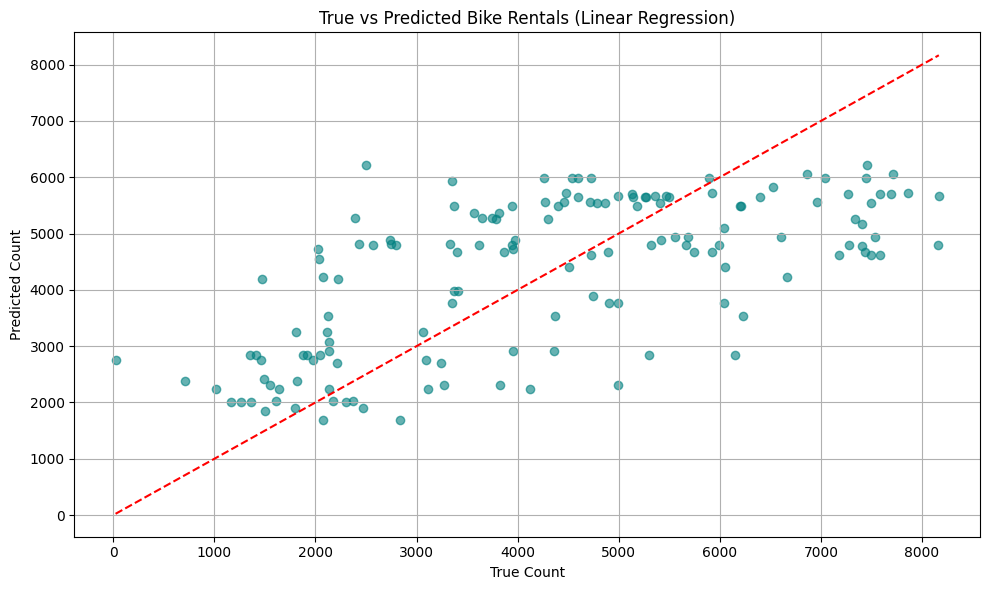

In [ ]:
import matplotlib.pyplot as plt

model_GLM.eval()
with torch.inference_mode():
   preds = np.expm1(model_GLM(X_test).detach().cpu().numpy())
   true = np.expm1(Y_test.cpu().numpy())

plt.figure(figsize=(10, 6))
plt.scatter(true, preds, alpha=0.6, color='teal')
plt.xlabel("True Count")
plt.ylabel("Predicted Count")
plt.title("True vs Predicted Bike Rentals (Linear Regression)")
plt.grid(True)
plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--')  # Ideal line
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(true, preds))
mae = mean_absolute_error(true, preds)
r2 = r2_score(true, preds)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R² Score: {r2:.4f}")

Test RMSE: 1529.05
Test MAE: 1286.96
Test R² Score: 0.4169
